In [1]:
%matplotlib inline
from google.colab import drive

drive.mount('/gdrive')

root = '/gdrive/My Drive/CycleGAN'

ModuleNotFoundError: No module named 'google.colab'

In [2]:
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import itertools
from torchvision.utils import save_image, make_grid

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

torch.manual_seed(470)
torch.cuda.manual_seed(470)

from pathlib import Path
from datetime import datetime

import gc

gc.collect()
torch.cuda.empty_cache()

now = datetime.now()


In [5]:
# Hyperparameters
ROOT_DIR = root
LOG_DIR = os.path.join(ROOT_DIR, "logs", now.strftime("%Y%m%d-%H%M%S"))
LOG_ITER = 20
CKPT_DIR = os.path.join(ROOT_DIR, "checkpoints")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCHSIZE = 10
LEARNING_RATE = 0.0002
MAX_EPOCH = 50

LAMBDA = 10

if not os.path.exists(CKPT_DIR):
    os.makedirs(CKPT_DIR)

LOG_DIR

'logs/20220122-145843'

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, path_X, path_Y=None, transform=None, test=False):
        self.path_X = glob.glob(os.path.join(path_X, "*.jpg"))
        self.test = test
        if test == False:
            self.path_Y = glob.glob(os.path.join(path_Y, "*.jpg"))
            self.length = max(len(self.path_X), len(self.path_Y))
        else:
            self.length = len(self.path_X)
        self.transform = transform

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img_X = Image.open(self.path_X[index % len(self.path_X)]).convert("RGB")
        if self.test == False:
            img_Y = Image.open(self.path_Y[index % len(self.path_Y)]).convert("RGB")

        if self.transform:
            img_X = self.transform(img_X)
            if self.test == False:
                img_Y = self.transform(img_Y)

        if self.test == False:
            return img_X, img_Y
        return img_X


In [ ]:
# Construct Data Pipeline
data_dir_X = os.path.join(Path(ROOT_DIR).parent, "dataset", "photo_jpg")
data_dir_Y = os.path.join(Path(ROOT_DIR).parent, "dataset", "monet_jpg")
transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

# Helper Functions
def initialize_weight(m):
    if isinstance(m, torch.nn.Conv2d):
        nn.init.normal_(m.weight.data, 0, 0.02)

print(len(glob.glob(os.path.join(data_dir_X, "*.jpg"))))
print(len(glob.glob(os.path.join(data_dir_Y, "*.jpg"))))


7038
300


In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.features = self.create_layers()

    def forward(self, x):
        return self.features(x)

    def create_layers(self):
        infos = [
            "c7s1-64",
            "d128",
            "d256",
            "R256",
            "R256",
            "R256",
            "R256",
            "R256",
            "R256",
            "R256",
            "R256",
            "R256",
            "u128",
            "u64",
            "c7s1-3",
        ]
        layers = []
        in_channels = 3
        for x in infos:
            if x.startswith("c7s1-64"):
                layers += [
                    nn.ReflectionPad2d(3),
                    nn.Conv2d(in_channels, int(x[5:]), kernel_size=7),
                    nn.InstanceNorm2d(int(x[5:])),
                    nn.ReLU(inplace=True),
                ]
                in_channels = int(x[5:])

            elif x.startswith("d"):
                layers += [
                    nn.Conv2d(
                        in_channels, int(x[1:]), kernel_size=3, stride=2, padding=1
                    ),
                    nn.InstanceNorm2d(int(x[1:])),
                    nn.ReLU(inplace=True),
                ]
                in_channels = int(x[1:])

            elif x.startswith("R"):
                layers += [ResidualBlock(in_channels)]

            elif x.startswith("u"):
                layers += [
                    nn.ConvTranspose2d(
                        in_channels,
                        int(x[1:]),
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.InstanceNorm2d(int(x[1:])),
                    nn.ReLU(inplace=True),
                ]
                in_channels = int(x[1:])
            elif x.startswith("c7s1-3"):
                layers += [
                    nn.ReflectionPad2d(3),
                    nn.Conv2d(in_channels, 3, 7),
                    nn.Tanh(),
                ]

        return nn.Sequential(*layers)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.features = self.create_layers()

    def forward(self, x):
        x = self.features(x)
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

    def create_layers(self):
        infos = [64, 128, 256, 512]
        layers = []
        in_channels = 3
        for x in infos:
            if x != 64:
                layers += [
                    nn.Conv2d(in_channels, x, kernel_size=4, stride=2),
                    nn.InstanceNorm2d(x),
                    nn.LeakyReLU(0.2, inplace=True),
                ]
                in_channels = x
            else:
                layers += [
                    nn.Conv2d(in_channels, x, kernel_size=4, stride=2),
                    nn.LeakyReLU(0.2, inplace=True),
                ]
                in_channels = x
        layers += [nn.Conv2d(in_channels, 1, 4, padding=1)]
        return nn.Sequential(*layers)


In [ ]:
train_dataset = ImageDataset(data_dir_X, data_dir_Y, transform=transform)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCHSIZE, shuffle=True, num_workers=2
)

Generator_XY = Generator().to(DEVICE).apply(initialize_weight)
Discriminator_X = Discriminator().to(DEVICE).apply(initialize_weight)

Generator_YX = Generator().to(DEVICE).apply(initialize_weight)
Discriminator_Y = Discriminator().to(DEVICE).apply(initialize_weight)

optimizer_generator = optim.Adam(
    itertools.chain(Generator_XY.parameters(), Generator_YX.parameters()),
    lr=LEARNING_RATE,
)
optimizer_discriminator_X = optim.Adam(Discriminator_X.parameters(), lr=LEARNING_RATE)
optimizer_discriminator_Y = optim.Adam(Discriminator_Y.parameters(), lr=LEARNING_RATE)


def schedule_lambda(epoch):
    return 1 - (epoch - MAX_EPOCH / 2 + np.abs(epoch - MAX_EPOCH / 2)) / (MAX_EPOCH)


scheduler_G = optim.lr_scheduler.LambdaLR(
    optimizer_generator, lr_lambda=schedule_lambda
)
scheduler_DX = optim.lr_scheduler.LambdaLR(
    optimizer_discriminator_X, lr_lambda=schedule_lambda
)
scheduler_DY = optim.lr_scheduler.LambdaLR(
    optimizer_discriminator_Y, lr_lambda=schedule_lambda
)

checkpoint is loaded!
[epoch: 1, iteration: 20] train loss : 9.865251


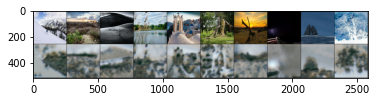

[epoch: 1, iteration: 40] train loss : 9.374253


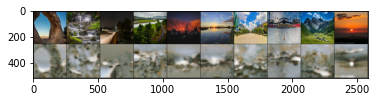

[epoch: 1, iteration: 60] train loss : 9.418864


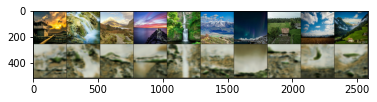

[epoch: 1, iteration: 80] train loss : 9.198009


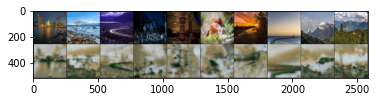

[epoch: 1, iteration: 100] train loss : 9.345711


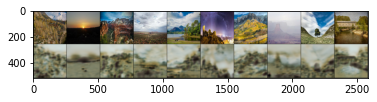

[epoch: 1, iteration: 120] train loss : 9.696311


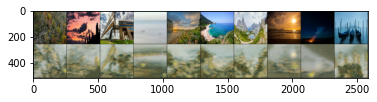

KeyboardInterrupt: ignored

In [ ]:
writer = SummaryWriter(LOG_DIR)
iteration = 0
ckpt_path = os.path.join(CKPT_DIR, "lastest.pt")
if os.path.exists(ckpt_path):
    ckpt = torch.load(ckpt_path, map_location=torch.device(DEVICE))
    try:
        optimizer_discriminator_X.load_state_dict(ckpt["optim_discriminator_X"])
        optimizer_discriminator_Y.load_state_dict(ckpt["optim_discriminator_Y"])
        optimizer_generator.load_state_dict(ckpt["optim_generator"])
        Discriminator_X.load_state_dict(ckpt["Discriminator_X"])
        Discriminator_Y.load_state_dict(ckpt["Discriminator_Y"])
        Generator_XY.load_state_dict(ckpt["Generator_XY"])
        Generator_YX.load_state_dict(ckpt["Generator_YX"])
    except RuntimeError as e:
        print("wrong checkpoint")
    else:
        print("checkpoint is loaded!")

for epoch in range(MAX_EPOCH):
    Generator_XY.train()
    Generator_YX.train()
    Discriminator_X.train()
    Discriminator_Y.train()
    for input_X, input_Y in train_dataloader:
        iteration += 1
        input_X = input_X.to(DEVICE)
        input_Y = input_Y.to(DEVICE)

        X_to_Y = Generator_XY(input_X).detach()
        Y_to_X = Generator_YX(input_Y).detach()

        MSELoss = torch.nn.MSELoss().to(DEVICE)
        L1Norm = torch.nn.L1Loss().to(DEVICE)

        # Train Generator
        result_XYY = Discriminator_Y(X_to_Y)
        result_YXX = Discriminator_X(Y_to_X)
        loss_GAN = (
            MSELoss(result_XYY, torch.ones_like(result_XYY))
            + MSELoss(result_YXX, torch.ones_like(result_YXX))
        ) / 2

        loss_cyc = (
            (
                L1Norm(Generator_YX(X_to_Y), input_X)
                + L1Norm(Generator_XY(Y_to_X), input_Y)
            )
            / 2
            * LAMBDA
        )

        loss_identity = (L1Norm(X_to_Y, input_Y) + L1Norm(Y_to_X, input_X)) / 2 * LAMBDA

        loss_G = loss_GAN + loss_cyc + loss_identity

        optimizer_generator.zero_grad()
        loss_G.backward()
        optimizer_generator.step()

        # Train Discriminator X
        result_XX = Discriminator_X(input_X)
        result_YXX = Discriminator_X(Y_to_X)

        loss_DX = (
            MSELoss(result_XX, torch.ones_like(result_XX))
            + MSELoss(result_YXX, torch.zeros_like(result_YXX))
        ) / 2

        optimizer_discriminator_X.zero_grad()
        loss_DX.backward()
        optimizer_discriminator_X.step()

        # Train Discriminator Y
        result_YY = Discriminator_Y(input_Y)
        result_XYY = Discriminator_Y(X_to_Y)

        loss_DY = (
            MSELoss(result_YY, torch.ones_like(result_YY))
            + MSELoss(result_XYY, torch.zeros_like(result_XYY))
        ) / 2

        optimizer_discriminator_Y.zero_grad()
        loss_DY.backward()
        optimizer_discriminator_Y.step()

        loss = loss_G.item() + loss_DX.item() + loss_DY.item()

        if iteration % LOG_ITER == 0 and writer is not None:
            writer.add_scalar("train_loss", loss, iteration)
            writer.add_scalar(
                "gan_loss", loss_DX.item() + loss_DY.item() + loss_GAN.item(), iteration
            )
            writer.add_scalar("cyc_loss", loss_cyc.item(), iteration)
            writer.add_scalar("identity_loss", loss_identity.item(), iteration)
            writer.add_scalar("generator_loss", loss_identity.item(), iteration)
            writer.add_scalar("discriminator_X_loss", loss_DX.item(), iteration)
            writer.add_scalar("discriminator_Y_loss", loss_DY.item(), iteration)
            print(
                "[epoch: {} iteration: {}] train loss : {:4f} GAN Loss : {:4f} Cyc Loss : {:4f} Ide Loss : {:4f}".format(
                    epoch + 1,
                    iteration,
                    loss,
                    loss_DX.item() + loss_DY.item() + loss_GAN.item(),
                    loss_cyc.item(),
                    loss_identity.item(),
                )
            )

            ckpt = {
                "Discriminator_X": Discriminator_X.state_dict(),
                "Discriminator_Y": Discriminator_Y.state_dict(),
                "Generator_XY": Generator_XY.state_dict(),
                "Generator_YX": Generator_YX.state_dict(),
                "optim_discriminator_X": optimizer_discriminator_X.state_dict(),
                "optim_discriminator_Y": optimizer_discriminator_Y.state_dict(),
                "optim_generator": optimizer_generator.state_dict(),
            }
            torch.save(ckpt, ckpt_path)

            shower = torch.cat(((input_X + 1) / 2, (X_to_Y + 1) / 2), 0)
            plt.imshow(make_grid(shower.cpu(), nrow=BATCHSIZE).permute(1, 2, 0))

            save_image(
                make_grid(shower.cpu(), nrow=BATCHSIZE),
                os.path.join(LOG_DIR, "iteration {}.jpg".format(iteration)),
            )
            plt.show()

    scheduler_G.step()
    scheduler_DX.step()
    scheduler_DY.step()
    print(
        "[epoch: {}] train loss : {:4f} GAN Loss : {:4f} Cyc Loss : {:4f} Ide Loss : {:4f}".format(
            epoch + 1,
            loss,
            loss_DX.item() + loss_DY.item() + loss_GAN.item(),
            loss_cyc.item(),
            loss_identity.item(),
        )
    )
